# Storytelling Exercise 

### Assignment:
How does one go about creating a data story? You have some pointers from the material you've just gone through, but they’re probably a bit on the abstract side when you’re just getting started. Also, storytelling is an art, so you have to get your imagination going. Here are some pointers to get those creative juices flowing. In the following sections we will work step-by-step to create your first Data Story

Pick a dataset - ideally the dataset for your Capstone. If for some reason you want to do this on a different data set, you can find one on Mode Analytics or Google's public data sets directory, or pick another one you like from elsewhere.

Get going by asking the following questions and looking for the answers with some code and plots:
*- Can you count something interesting?
*- Can you find some trends (high, low, increase, decrease, anomalies)?
*- Can you make a bar plot or a histogram?
*- Can you compare two related quantities?
*- Can you make a scatterplot?
*- Can you make a time-series plot?

Having made these plots, what are some insights you get from them? Do you see any correlations? Is there a hypothesis you would like to investigate further? What other questions do they lead you to ask?

By now you’ve asked a bunch of questions, and found some neat insights. Is there an interesting narrative, a way of presenting the insights using text and plots from the above, that tells a compelling story? As you work out this story, what are some other trends/relationships you think will make it more complete?

Submission Requirements: Submit links to a Github repository containing a Jupyter notebook. The notebook should contain:

The questions you asked The trends you investigated The resulting visualizations and conclusions. In case the data set is too large to commit to Github, please include a link to the data set inside the Jupyter notebook.

## Data Acquisition
Mine is from [Kaggle](https://www.kaggle.com/tunguz/pharmaceutical-drug-spending-by-countries) and it explores pharmaceutical drug spending by countries with indicators such as a share of total health spending, in USD per capita (using economy-wide PPPs) and as a share of GDP. Plus, total spending by each countries in the specific year. Data comes from [Organisation for Economic Cooperation and Development](https://data.oecd.org/healthres/pharmaceutical-spending.htm). Population data comes from [DataHub](http://datahub.io/core/population)Columns such as 'Total Spend' was calculated using 'US dollars per capita' and 'population data'. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity

import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
# Set chart defaults
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [3]:
drug_spending_df = pd.read_csv(r'C:\Users\yuvem\OneDrive\Documents\GitHub\Springboard_\Storytelling\data_csv.csv')
drug_spending_df.head()

,LOCATION,TIME,PC_HEALTHXP,PC_GDP,USD_CAP,FLAG_CODES,TOTAL_SPEND
0,AUS,1971,15.992,0.727,35.720,NaN,462.11
1,AUS,1972,15.091,0.686,36.056,NaN,475.11
2,AUS,1973,15.117,0.681,39.871,NaN,533.47
3,AUS,1974,14.771,0.755,47.559,NaN,652.65
4,AUS,1975,11.849,0.682,47.561,NaN,660.76


## Data Cleaning and Wrangling

In [4]:
# Let's clean
drug_spending_df.rename({'LOCATION':'Location', 'TIME':'Year', 'PC_HEALTHXP':'Per_Capita_HealthXP', 'USD_CAP':'USD_Cap', 'FLAG_CODES':'Flag_Code', 'TOTAL_SPEND':'Tot_Spend'}, axis=1, inplace=True)
drug_spending_df

,Location,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Flag_Code,Tot_Spend
0,AUS,1971,15.992,0.727,35.720,NaN,462.11
1,AUS,1972,15.091,0.686,36.056,NaN,475.11
2,AUS,1973,15.117,0.681,39.871,NaN,533.47
3,AUS,1974,14.771,0.755,47.559,NaN,652.65
4,AUS,1975,11.849,0.682,47.561,NaN,660.76
...,...,...,...,...,...,...,...
1031,LTU,2012,28.942,1.820,448.728,NaN,1340.70
1032,LTU,2013,28.173,1.728,461.178,NaN,1364.02
1033,LTU,2014,27.836,1.724,485.245,NaN,1422.92
1034,LTU,2015,26.784,1.745,504.422,NaN,1465.30


In [5]:
drug_spending_df.Flag_Code.unique()

array([nan, 'B', 'D', 'P'], dtype=object)

In [6]:
drug_spending_df.Flag_Code.isnull().sum() # we got 973. That's 93% of data missing for Flag Codes, we can drop it

973

In [7]:
drug_spending_df = drug_spending_df.drop(columns='Flag_Code')

In [8]:
drug_spending_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Location             1036 non-null   object 
 1   Year                 1036 non-null   int64  
 2   Per_Capita_HealthXP  1036 non-null   float64
 3   PC_GDP               1036 non-null   float64
 4   USD_Cap              1036 non-null   float64
 5   Tot_Spend            1036 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 48.7+ KB


In [9]:
drug_spending_df

,Location,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend
0,AUS,1971,15.992,0.727,35.720,462.11
1,AUS,1972,15.091,0.686,36.056,475.11
2,AUS,1973,15.117,0.681,39.871,533.47
3,AUS,1974,14.771,0.755,47.559,652.65
4,AUS,1975,11.849,0.682,47.561,660.76
...,...,...,...,...,...,...
1031,LTU,2012,28.942,1.820,448.728,1340.70
1032,LTU,2013,28.173,1.728,461.178,1364.02
1033,LTU,2014,27.836,1.724,485.245,1422.92
1034,LTU,2015,26.784,1.745,504.422,1465.30


In [10]:
drug_spending_df[drug_spending_df['Location'].str.contains('USA')]

,Location,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend
956,USA,2000,11.365,1.421,518.109,146190.88
957,USA,2001,11.729,1.545,575.975,164134.99
958,USA,2002,12.075,1.686,643.351,185043.96
959,USA,2003,12.327,1.782,707.226,205171.87
960,USA,2004,12.505,1.818,762.271,223196.99
961,USA,2005,12.471,1.814,803.701,237506.99
962,USA,2006,12.725,1.866,866.302,258487.11
963,USA,2007,12.641,1.884,905.301,272704.91
964,USA,2008,12.399,1.896,917.815,279102.00
965,USA,2009,12.331,2.015,946.894,290480.12


In [11]:
drug_spending_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Location             1036 non-null   object 
 1   Year                 1036 non-null   int64  
 2   Per_Capita_HealthXP  1036 non-null   float64
 3   PC_GDP               1036 non-null   float64
 4   USD_Cap              1036 non-null   float64
 5   Tot_Spend            1036 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 48.7+ KB


In [12]:
cols_ = ['Per_Capita_HealthXP', 'PC_GDP', 'USD_Cap', 'Tot_Spend']
drug_spending_df[cols_] = drug_spending_df[cols_].round(2)
drug_spending_df

,Location,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend
0,AUS,1971,15.99,0.73,35.72,462.11
1,AUS,1972,15.09,0.69,36.06,475.11
2,AUS,1973,15.12,0.68,39.87,533.47
3,AUS,1974,14.77,0.76,47.56,652.65
4,AUS,1975,11.85,0.68,47.56,660.76
...,...,...,...,...,...,...
1031,LTU,2012,28.94,1.82,448.73,1340.70
1032,LTU,2013,28.17,1.73,461.18,1364.02
1033,LTU,2014,27.84,1.72,485.24,1422.92
1034,LTU,2015,26.78,1.74,504.42,1465.30


In [13]:
drug_spending_df.isnull().sum()

Location               0
Year                   0
Per_Capita_HealthXP    0
PC_GDP                 0
USD_Cap                0
Tot_Spend              0
dtype: int64

In [14]:
drug_spending_df.Tot_Spend.unique()

array([  462.11,   475.11,   533.47, ...,  1422.92,  1465.3 , 44655.62])

In [15]:
drug_spending_df.Tot_Spend.isnull().sum()

0

In [16]:
drug_spending_df = drug_spending_df.sort_index()

### Create a new column for Region

This will make things simpler when comparing values. 

In [17]:
drug_spending_df['Location']

0       AUS
1       AUS
2       AUS
3       AUS
4       AUS
       ... 
1031    LTU
1032    LTU
1033    LTU
1034    LTU
1035    RUS
Name: Location, Length: 1036, dtype: object

In [18]:
region = {
    'AUS' : 'Oceania',
    'AUT' : 'Europe',
    'BEL' : 'Europe',
    'CAN' : 'North America',
    'CZE' : 'Europe',
    'DNK' : 'Europe',
    'FIN' : 'Europe',
    'FRA' : 'Europe',
    'DEU' : 'Europe',
    'GRC' : 'Europe',
    'HUN' : 'Europe',
    'ISL' : 'Asia',
    'ISR' : 'Asia',
    'IRL' : 'Europe',
    'ITA' : 'Europe',
    'JPN' : 'Asia',
    'KOR' : 'Asia',
    'LTU' : 'Europe',
    'LUX' : 'Europe',
    'LVA' : 'Europe',
    'MEX' : 'North America',
    'NLD' : 'Europe',
    'NZL' : 'Oceania',
    'NOR' : 'Europe',
    'POL' : 'Europe',
    'PRT' : 'Europe',
    'SVK' : 'Europe',
    'ESP' : 'Europe',
    'SWE' : 'Europe',
    'CHE' : 'Europe',
    'TUR' : 'Asia',
    'GBR' : 'Europe',
    'RUS' : 'Europe',
    'USA' : 'North America',
    'EST' : 'Europe',
    'SVN' : 'Europe'
}

drug_spending_df['Region'] = drug_spending_df['Location'].map(region)

# value counts for each Region
drug_spending_df['Region'].value_counts() 

drug_spending_df.sample(4)

,Location,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend,Region
915,TUR,1982,12.90,0.28,13.61,626.45,Asia
505,JPN,1984,19.46,1.25,152.54,18307.07,Asia
570,KOR,2004,29.25,1.40,320.68,15419.01,Asia
115,CAN,1974,10.03,0.61,40.56,923.69,North America


In [19]:
drug_spending_df['Region'].unique()

array(['Oceania', 'Europe', 'North America', 'Asia'], dtype=object)

### Create a new column for Decades

Realizing years are entered as 1971, 1972, 1973 and so on, we can make things simpler, again, by adding column designated for decades. 

In [20]:
decade = {
    1970 : '70s', 
    1971 : '70s', 
    1972 : '70s', 
    1973 : '70s', 
    1974 : '70s', 
    1975 : '70s', 
    1976 : '70s', 
    1977 : '70s', 
    1978 : '70s', 
    1979 : '70s', 
    1980 : '80s', 
    1981 : '80s', 
    1982 : '80s', 
    1983 : '80s', 
    1984 : '80s',
    1985 : '80s', 
    1986 : '80s', 
    1987 : '80s', 
    1988 : '80s', 
    1989 : '80s',
    1990 : '90s', 
    1991 : '90s', 
    1992 : '90s', 
    1993 : '90s', 
    1994 : '90s',
    1995 : '90s', 
    1996 : '90s', 
    1997 : '90s', 
    1998 : '90s', 
    1999 : '90s',
    2000 : '2000s', 
    2001 : '2000s', 
    2002 : '2000s', 
    2003 : '2000s', 
    2004 : '2000s',
    2005 : '2000s', 
    2006 : '2000s', 
    2007 : '2000s', 
    2008 : '2000s', 
    2009 : '2000s',
    2010 : '2010s', 
    2011 : '2010s', 
    2012 : '2010s', 
    2013 : '2010s', 
    2014 : '2010s',
    2015 : '2010s', 
    2016 : '2010s'}

drug_spending_df['Decade'] = drug_spending_df['Year'].map(decade)

# see value counts of each Decade
drug_spending_df['Decade'].value_counts()         

# see new column called Decade
drug_spending_df.sample(4)

,Location,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend,Region,Decade
840,SWE,1973,9.33,0.56,33.31,271.05,Europe,70s
910,CHE,2012,14.31,1.59,914.40,7312.30,Europe,2010s
157,CZE,1991,21.50,0.84,96.46,994.38,Europe,90s
134,CAN,1993,13.38,1.23,263.39,7594.46,North America,90s


In [21]:
drug_spending_df.Decade.dtype

dtype('O')

In [50]:
drug_spending_df.head()

,Location,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend,Region,Decade
0,AUS,1971,15.99,0.73,35.72,462.11,Oceania,70s
1,AUS,1972,15.09,0.69,36.06,475.11,Oceania,70s
2,AUS,1973,15.12,0.68,39.87,533.47,Oceania,70s
3,AUS,1974,14.77,0.76,47.56,652.65,Oceania,70s
4,AUS,1975,11.85,0.68,47.56,660.76,Oceania,70s


In [22]:
# make separate datasets for each decade
_70s = drug_spending_df[drug_spending_df['Decade'].str.contains('70s')]
_80s = drug_spending_df[drug_spending_df['Decade'].str.contains('80s')]
_90s = drug_spending_df[drug_spending_df['Decade'].str.contains('90s')]
_2000s = drug_spending_df[drug_spending_df['Decade'].str.contains('2000s')]
_2010s = drug_spending_df[drug_spending_df['Decade'].str.contains('2010s')]

# Sanity check
_2010s.sample(10)

,Location,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend,Region,Decade
110,BEL,2015,14.21,1.49,678.97,7654.85,Europe,2010s
985,EST,2012,20.15,1.17,305.56,404.17,Europe,2010s
430,ISL,2012,14.45,1.26,508.58,163.11,Asia,2010s
580,KOR,2014,22.87,1.63,548.01,27809.68,Asia,2010s
502,ITA,2015,17.93,1.61,601.02,36500.17,Europe,2010s
616,MEX,2011,28.20,1.62,265.79,31652.94,North America,2010s
983,EST,2010,20.46,1.30,280.19,373.06,Europe,2010s
1018,LVA,2011,26.09,1.45,287.48,592.12,Europe,2010s
620,MEX,2015,27.20,1.60,286.82,36108.67,North America,2010s
784,PRT,2012,16.64,1.56,411.46,4326.49,Europe,2010s


In [23]:
# make separate datasets for each region
ds_Oceania = drug_spending_df[drug_spending_df['Region'].str.contains('Oceania')]
ds_Asia = drug_spending_df[drug_spending_df['Region'].str.contains('Asia')]
ds_NorthAmerica = drug_spending_df[drug_spending_df['Region'].str.contains('North America')]
ds_Europe = drug_spending_df[drug_spending_df['Region'].str.contains('Europe')]

ds_Asia.sample(4)

,Location,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend,Region,Decade
524,JPN,2003,19.53,1.49,429.38,54839.30,Asia,2000s
505,JPN,1984,19.46,1.25,152.54,18307.07,Asia,80s
578,KOR,2012,24.81,1.67,535.72,26892.96,Asia,2010s
569,KOR,2003,29.38,1.40,298.59,14300.31,Asia,2000s


In [24]:
# We'll make a separate dataframe that has Decade as index, Region as columns, and total spending as values
spending_table = drug_spending_df.pivot_table(index=['Decade'], columns=['Region'], values=['Tot_Spend'], fill_value=0)
spending_table

Tot_Spend                                           
Region          Asia        Europe  North America       Oceania
Decade                                                         
2000s   22440.852286   8098.358100   89464.692000   6636.164286
2010s   30709.423636  10815.053907  133261.786471  13525.462000
70s       118.699000   1346.353291    1038.501000    524.563636
80s      4935.155588   2897.675289    3185.775000    792.365000
90s     13051.791212   5410.626149    8338.174545   2239.891667

## EDA and Early Data Visualization

<AxesSubplot:xlabel='Decade'>

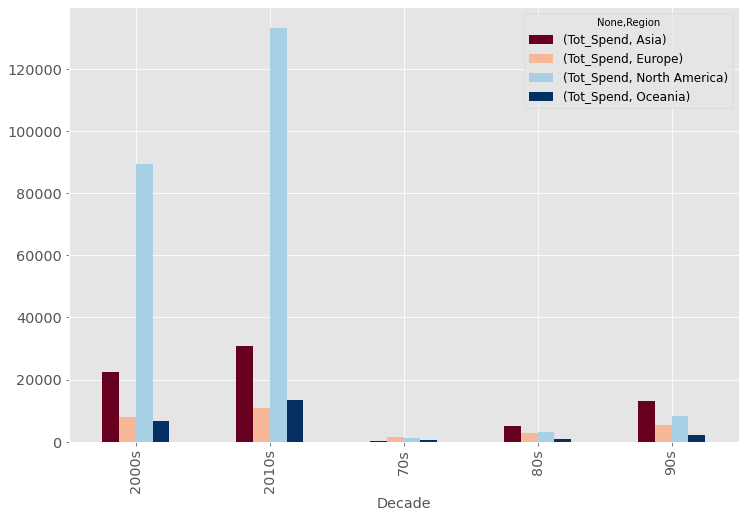

In [25]:
spending_table.plot(kind='bar', cmap='RdBu')

We can already start to see that the 2000s and 2010s have the most drug spending and the 70s has the least (perhaps not enough data collected). 

### Create heamaps

##### Correlation heatmap: by Region

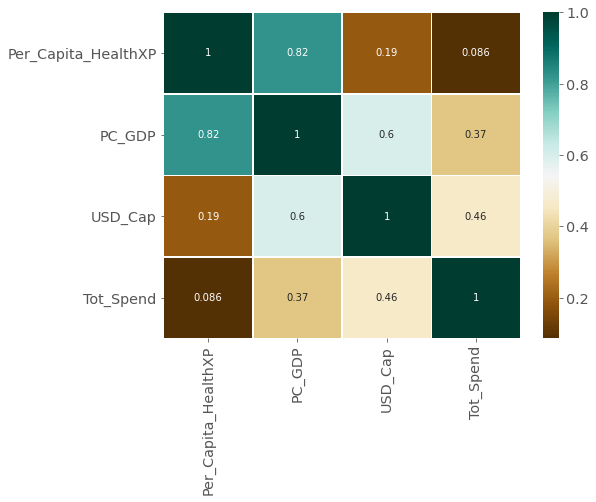

In [26]:
# Heatmap for Europe
col_Europe = ds_Europe.columns[2:6]
ds_Europe_corr = ds_Europe[col_Europe]

matrix_Europe = ds_Europe_corr.corr()

_= plt.figure(figsize=(8,6))
heatmap = sns.heatmap(matrix_Europe, annot=True, cmap='BrBG', linewidth=0.4)
plt.show()

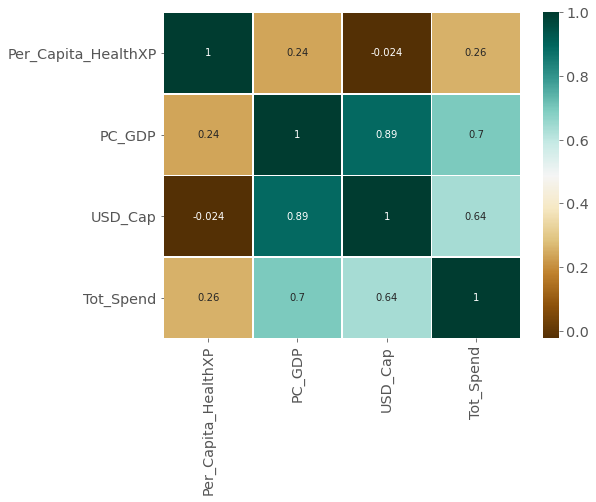

In [27]:
# Heatmap for Asia
col_Asia = ds_Asia.columns[2:6]
ds_Asia_corr = ds_Asia[col_Asia]

matrix_Asia = ds_Asia_corr.corr()

_= plt.figure(figsize=(8,6))
heatmap = sns.heatmap(matrix_Asia, annot=True, cmap='BrBG', linewidth=0.4)
plt.show()

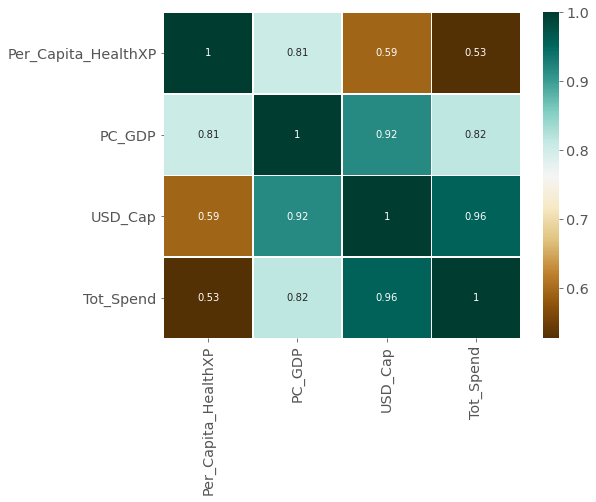

In [28]:
# Heatmap for Oceania
col_Oceania = ds_Oceania.columns[2:6]
ds_Oceania_corr = ds_Oceania[col_Asia]

matrix_Oceania = ds_Oceania_corr.corr()

_= plt.figure(figsize=(8,6))
heatmap = sns.heatmap(matrix_Oceania, annot=True, cmap='BrBG', linewidth=0.4)
plt.show()

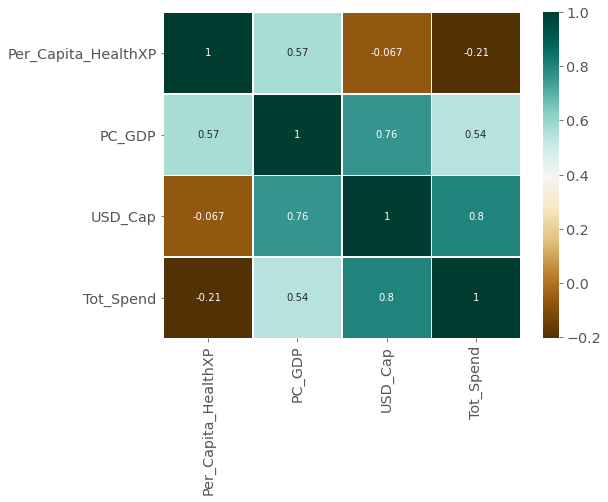

In [29]:
# Heatmap for North America
col_NorthAmerica = ds_NorthAmerica.columns[2:6]
ds_NorthAmerica_corr = ds_NorthAmerica[col_Asia]

matrix_NorthAmerica = ds_NorthAmerica_corr.corr()

_= plt.figure(figsize=(8,6))
heatmap = sns.heatmap(matrix_NorthAmerica, annot=True, cmap='BrBG', linewidth=0.4)
plt.show()

As a side note, according to investopedia.com, er capita gross domestic product (GDP) measures a country's economic output per person and is calculated by dividing the GDP of a country by its population. Per capita GDP is a **global measure for gauging the prosperity of nations and is used by economists, along with GDP, to analyze the prosperity of a country based on its economic growth.**

Before I move on to making heamaps by Decade, I will introduce Descriptive statistics for each Region.

In [30]:
ds_Europe.describe()

,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend
count,746.000000,746.00000,746.000000,746.000000,746.000000
mean,1997.536193,16.23244,1.189357,299.170710,6462.788003
std,12.342077,6.63164,0.471214,193.425294,10512.243447
min,1970.000000,5.54000,0.320000,6.780000,44.630000
25%,1989.000000,10.67000,0.780000,125.812500,831.480000
50%,1999.000000,14.78000,1.150000,281.825000,2282.905000
75%,2008.000000,20.45250,1.530000,447.487500,5620.632500
max,2016.000000,40.24000,2.800000,1056.050000,62569.490000


In [31]:
ds_Asia.describe()

,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend
count,144.000000,144.000000,144.000000,144.00000,144.000000
mean,1994.597222,18.883194,1.088819,256.50250,14318.857847
std,12.702799,4.534889,0.408532,202.79638,23592.118313
min,1970.000000,10.710000,0.210000,3.16000,6.290000
25%,1984.750000,14.537500,0.790000,65.84250,115.445000
50%,1995.000000,19.185000,1.140000,235.74500,1761.150000
75%,2006.000000,21.795000,1.332500,409.50250,22096.935000
max,2016.000000,31.630000,2.040000,802.73000,102168.650000


In [32]:
ds_Oceania.describe()

,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend
count,68.000000,68.000000,68.000000,68.000000,68.000000
mean,1991.647059,12.879559,0.876765,202.281471,3271.605294
std,11.739415,2.294644,0.259129,171.532076,4187.628578
min,1971.000000,8.980000,0.520000,24.600000,70.180000
25%,1982.750000,10.752500,0.655000,72.600000,539.432500
50%,1991.000000,13.375000,0.855000,139.955000,1049.880000
75%,2001.250000,15.015000,1.042500,264.065000,4454.450000
max,2014.000000,16.060000,1.340000,627.400000,14503.870000


In [33]:
ds_NorthAmerica.describe()

,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend
count,78.000000,78.000000,78.000000,78.000000,78.000000
mean,1998.448718,16.570513,1.401538,407.638718,65171.202692
std,12.874668,7.589305,0.502234,317.246492,104861.484527
min,1970.000000,8.880000,0.580000,34.510000,735.930000
25%,1989.250000,11.477500,0.930000,128.642500,5179.217500
50%,2002.000000,13.065000,1.545000,286.935000,18430.410000
75%,2008.750000,18.202500,1.867500,675.247500,34247.442500
max,2015.000000,35.890000,2.130000,1162.400000,373009.910000


Quick insights:
- North America has a high standard deviation (6 digits!) for total spending. High variability or the average variation around the mean is large.
- Europe has the highest count for PC_GDP and USD_Cap.
- The mean and standard deviation for all regions are in range 0.26-1. 
- Asia and North America have the highest max total spending. 

#### Correlation heatmap: by Decade

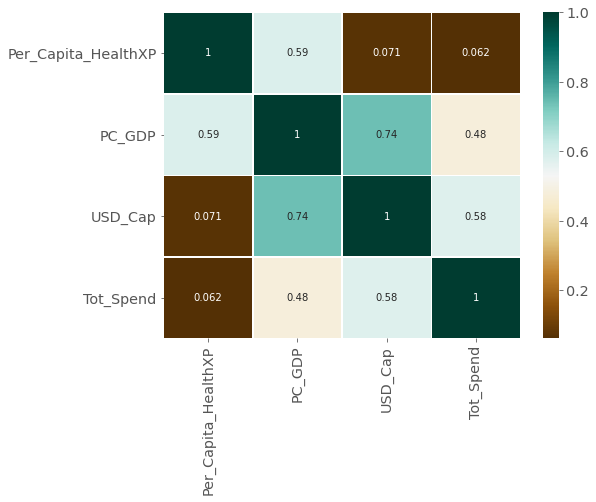

In [34]:
# Heatmap for the 70s
col_70s = _70s.columns[2:6]
ds_70s_corr = _70s[col_Europe]

matrix_70s = ds_70s_corr.corr()

_= plt.figure(figsize=(8,6))
heatmap = sns.heatmap(matrix_70s, annot=True, cmap='BrBG', linewidth=0.4)
plt.show()

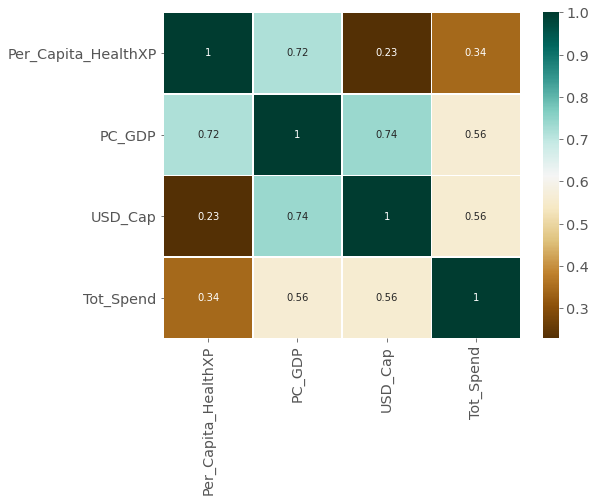

In [35]:
# Heatmap for the 80s
col_80s = _80s.columns[2:6]
ds_80s_corr = _80s[col_Europe]

matrix_80s = ds_80s_corr.corr()

_= plt.figure(figsize=(8,6))
heatmap = sns.heatmap(matrix_80s, annot=True, cmap='BrBG', linewidth=0.4)
plt.show()

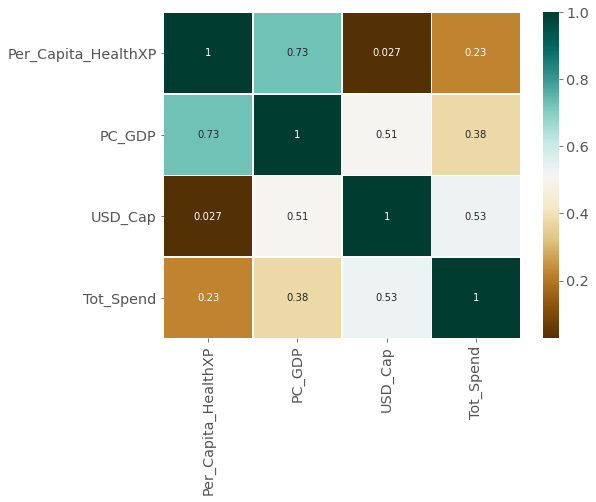

In [36]:
# Heatmap for the 90s
col_90s = _90s.columns[2:6]
ds_90s_corr = _90s[col_Europe]

matrix_90s = ds_90s_corr.corr()

_= plt.figure(figsize=(8,6))
heatmap = sns.heatmap(matrix_90s, annot=True, cmap='BrBG', linewidth=0.4)
plt.show()

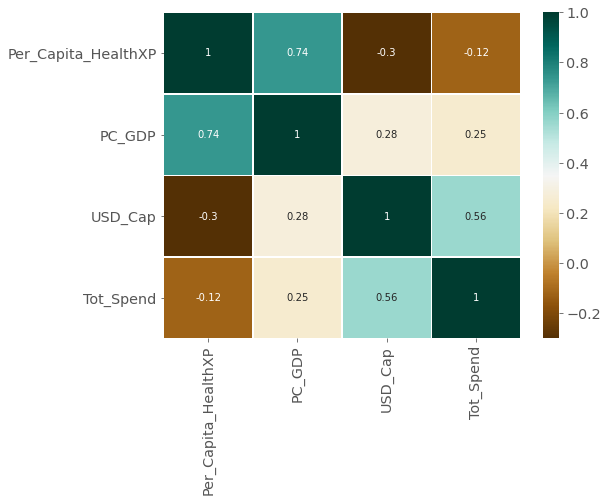

In [37]:
# Heatmap for the 2000s
col_2000s = _2000s.columns[2:6]
ds_2000s_corr = _2000s[col_Europe]

matrix_2000s = ds_2000s_corr.corr()

_= plt.figure(figsize=(8,6))
heatmap = sns.heatmap(matrix_2000s, annot=True, cmap='BrBG', linewidth=0.4)
plt.show()

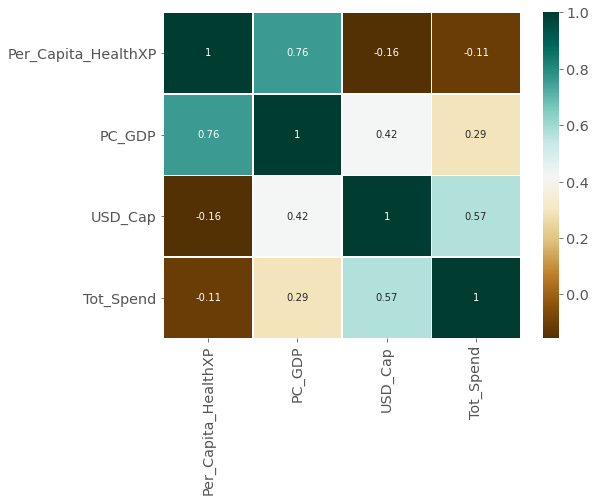

In [38]:
# Heatmap for the 2010s
col_2010s = _2010s.columns[2:6]
ds_2010s_corr = _2010s[col_Europe]

matrix_2010s = ds_2010s_corr.corr()

_= plt.figure(figsize=(8,6))
heatmap = sns.heatmap(matrix_2010s, annot=True, cmap='BrBG', linewidth=0.4)
plt.show()

Quick insights:
- 2000s and 2010s have the lowest correlation betwen Per_Capita_HealthXP and Tot_Spend.
- The 70s and 80s have the highest correlation between USD_Cap and PC_GDP, a tie at 0.74. 
- From the 80s-2010s, the correlation between Per_Capita_HealthXP and PC_GDP are around 0.72-0.76, while for the 70s it's 0.58.

#### Descriptive Statistics for each Decade

In [39]:
_70s.describe()

,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend
count,120.000000,120.000000,120.000000,120.000000,120.000000
mean,1974.708333,14.112333,0.720583,43.110750,1040.759167
std,2.876727,5.303094,0.246301,22.809518,1746.835164
min,1970.000000,5.540000,0.320000,3.160000,6.290000
25%,1972.000000,9.797500,0.570000,28.235000,129.382500
50%,1975.000000,13.835000,0.680000,41.845000,448.730000
75%,1977.000000,16.322500,0.885000,51.492500,908.165000
max,1979.000000,28.280000,1.270000,117.940000,9214.070000


In [40]:
_80s.describe()

,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend
count,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1984.654054,13.637568,0.816703,105.818216,3060.102973
std,2.887247,4.835049,0.277366,54.910465,5277.116018
min,1980.000000,6.150000,0.210000,12.300000,27.840000
25%,1982.000000,10.060000,0.610000,68.700000,405.760000
50%,1985.000000,12.430000,0.740000,93.940000,1064.230000
75%,1987.000000,16.480000,1.050000,131.620000,2814.520000
max,1989.000000,25.950000,1.550000,272.150000,28890.770000


In [41]:
_90s.describe()

,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend
count,236.000000,236.000000,236.000000,236.000000,236.000000
mean,1994.521186,15.966017,1.092542,218.055169,6373.711992
std,2.857535,5.598500,0.336175,74.779676,9220.811133
min,1990.000000,7.620000,0.540000,43.850000,56.150000
25%,1992.000000,11.877500,0.817500,163.702500,1070.962500
50%,1995.000000,14.560000,1.025000,213.480000,2240.145000
75%,1997.000000,20.007500,1.330000,280.177500,7197.222500
max,1999.000000,34.810000,2.250000,396.640000,40592.070000


In [42]:
_2000s.describe()

,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend
count,300.000000,300.000000,300.000000,300.000000,300.000000
mean,2004.716667,18.763333,1.438300,414.383567,17840.046767
std,2.828969,7.007835,0.412963,142.380383,42304.343123
min,2000.000000,7.610000,0.630000,96.570000,110.830000
25%,2002.000000,13.607500,1.170000,312.840000,1670.087500
50%,2005.000000,17.265000,1.465000,412.495000,4100.035000
75%,2007.000000,22.542500,1.700000,500.257500,16560.757500
max,2009.000000,40.240000,2.570000,946.890000,290480.120000


In [43]:
_2010s.describe()

,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend
count,195.000000,195.000000,195.000000,195.000000,195.000000
mean,2012.548718,17.351179,1.467179,539.194462,23803.887897
std,1.753181,6.663028,0.442472,172.123849,56736.127004
min,2010.000000,6.760000,0.510000,265.790000,160.240000
25%,2011.000000,12.510000,1.180000,421.595000,2362.345000
50%,2013.000000,15.680000,1.520000,526.460000,5473.660000
75%,2014.000000,21.200000,1.695000,628.570000,26652.845000
max,2016.000000,35.000000,2.800000,1162.400000,373009.910000


Quick insights:
- 2010s has the highest Tot_Spend max while 70s has the lowest. 
- 2000s has the highest count in USD_Cap and Per_Capita_HealthXP.
- The mean for USD_Cap and Tot_Spendd for the 70s is really low compared to the other decades.

In [44]:
ds_Europe.PC_GDP

44      0.78
45      0.78
46      0.80
47      0.84
48      0.85
        ... 
1031    1.82
1032    1.73
1033    1.72
1034    1.74
1035    1.29
Name: PC_GDP, Length: 746, dtype: float64

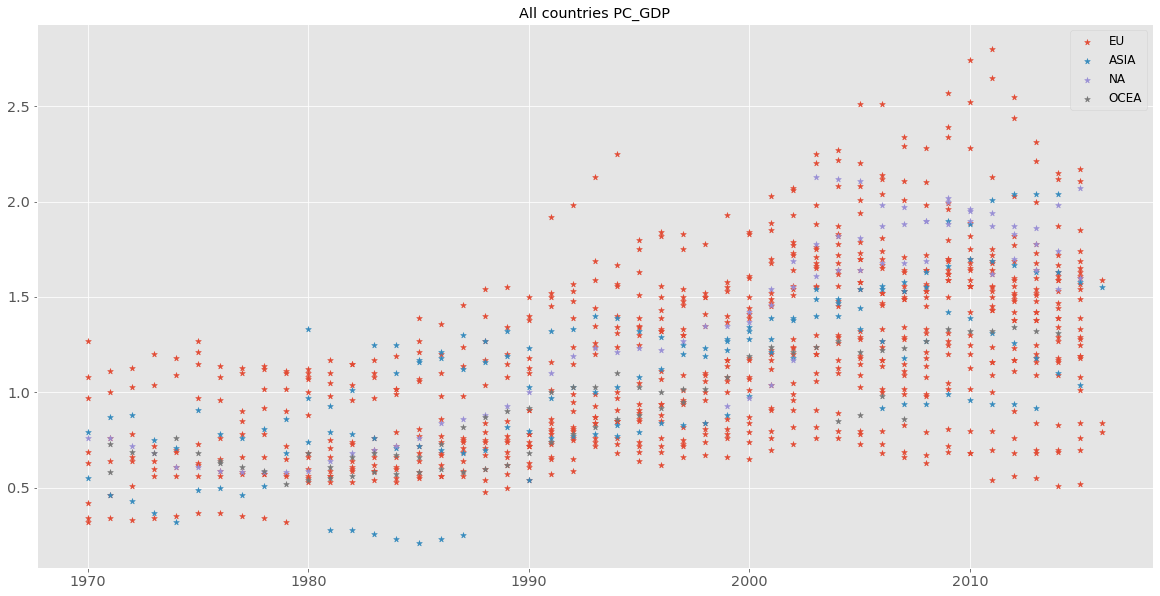

In [45]:
# of All countries PC_GDP
plt.figure(figsize=(20,10))
plt.title('All countries PC_GDP')

# Asia
plt.scatter(ds_Europe.Year,ds_Europe.PC_GDP, marker='*', label ='EU')
plt.scatter(ds_Asia.Year,ds_Asia.PC_GDP, marker='*', label ='ASIA')
plt.scatter(ds_NorthAmerica.Year,ds_NorthAmerica.PC_GDP, marker='*', label ='NA')
plt.scatter(ds_Oceania.Year,ds_Oceania.PC_GDP, marker='*', label ='OCEA')
plt.legend()

## Pie Charts by Region

array([<AxesSubplot:ylabel='mean'>], dtype=object)

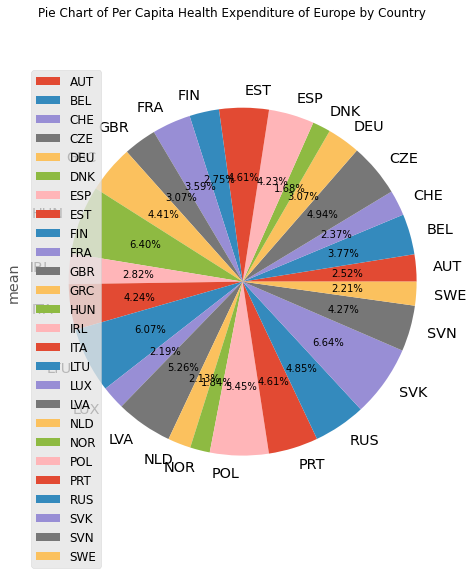

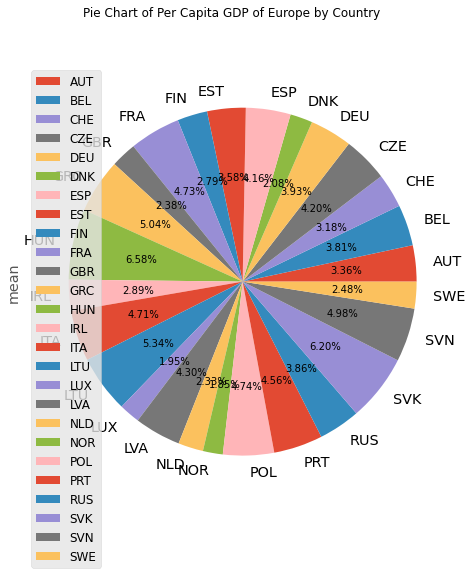

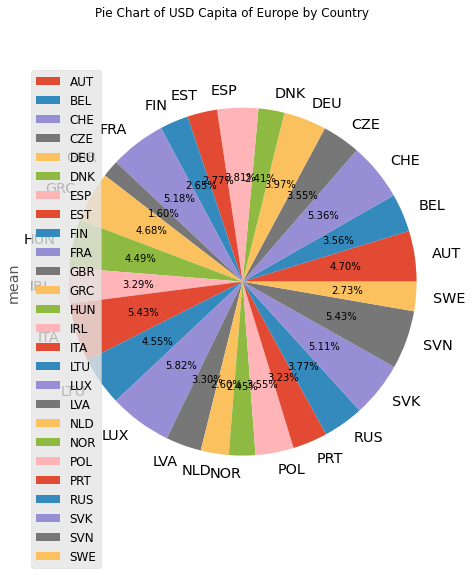

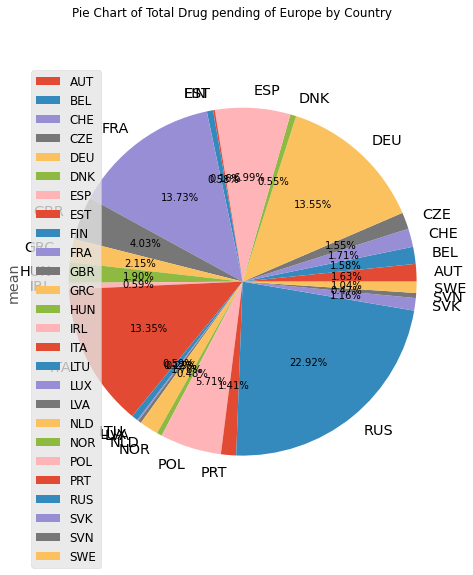

In [46]:
# Pie chart for Europe
ds_Europe_pie = ds_Europe.groupby(drug_spending_df['Location']).agg(['mean'])

ds_Europe_pie.Per_Capita_HealthXP.plot.pie(
    subplots =True,
    figsize=(12,8), 
    radius= 1.0, 
    autopct='%0.2f%%', 
    title ='Pie Chart of Per Capita Health Expenditure of Europe by Country')

ds_Europe_pie.PC_GDP.plot.pie(
    subplots =True,
    figsize=(12,8), 
    radius= 1.0, 
    autopct='%0.2f%%', 
    title ='Pie Chart of Per Capita GDP of Europe by Country')

ds_Europe_pie.USD_Cap.plot.pie(
    subplots =True,
    figsize=(12,8), 
    radius= 1.0, 
    autopct='%0.2f%%', 
    title ='Pie Chart of USD Capita of Europe by Country')

ds_Europe_pie.Tot_Spend.plot.pie(
    subplots =True,
    figsize=(12,8), 
    radius= 1.0, 
    autopct='%0.2f%%', 
    title ='Pie Chart of Total Drug pending of Europe by Country')

array([<AxesSubplot:ylabel='mean'>], dtype=object)

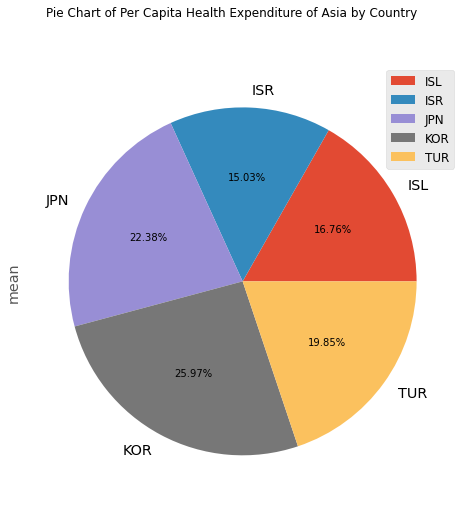

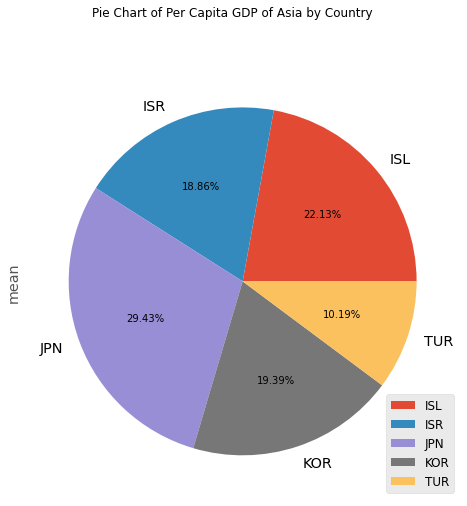

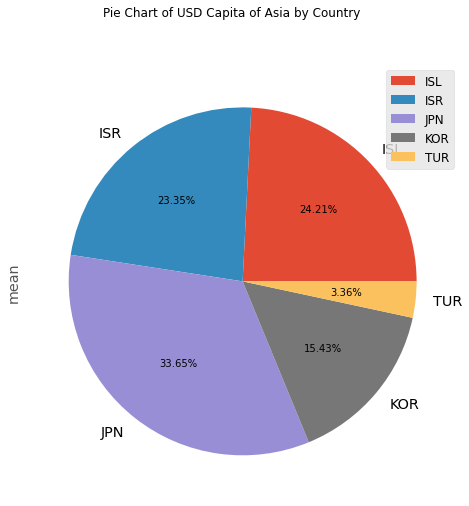

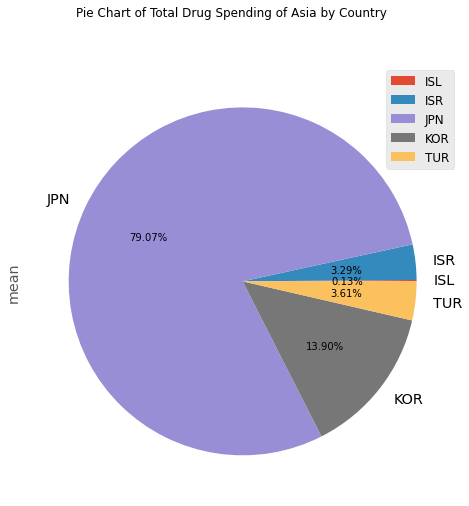

In [47]:
# Pie chart for Asia
ds_Asia_pie = ds_Asia.groupby(drug_spending_df['Location']).agg(['mean'])

ds_Asia_pie.Per_Capita_HealthXP.plot.pie(
    subplots =True,
    figsize=(12,8), 
    radius= 1.0, 
    autopct='%0.2f%%', 
    title ='Pie Chart of Per Capita Health Expenditure of Asia by Country')

ds_Asia_pie.PC_GDP.plot.pie(
    subplots =True,
    figsize=(12,8), 
    radius= 1.0, 
    autopct='%0.2f%%', 
    title ='Pie Chart of Per Capita GDP of Asia by Country')

ds_Asia_pie.USD_Cap.plot.pie(
    subplots =True,
    figsize=(12,8), 
    radius= 1.0, 
    autopct='%0.2f%%', 
    title ='Pie Chart of USD Capita of Asia by Country')

ds_Asia_pie.Tot_Spend.plot.pie(
    subplots =True,
    figsize=(12,8), 
    radius= 1.0, 
    autopct='%0.2f%%', 
    title ='Pie Chart of Total Drug Spending of Asia by Country')

array([<AxesSubplot:ylabel='mean'>], dtype=object)

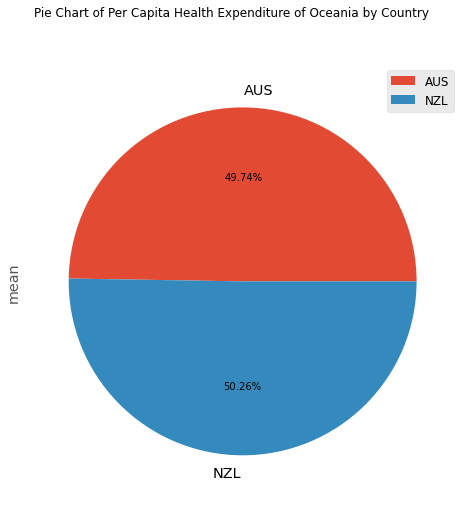

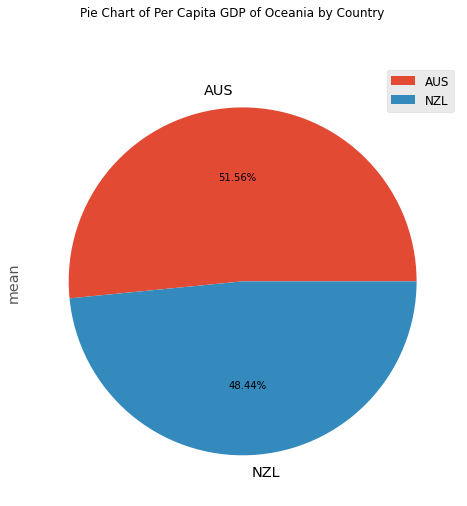

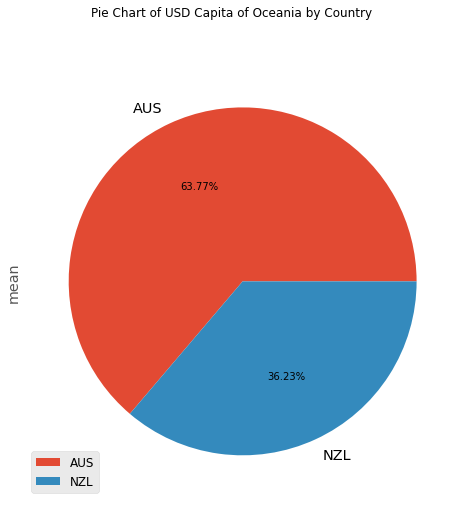

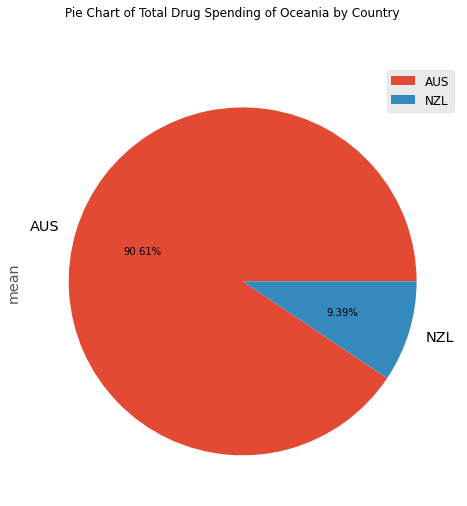

In [48]:
# Pie chart for Oceania
ds_Oceania_pie = ds_Oceania.groupby(drug_spending_df['Location']).agg(['mean'])

ds_Oceania_pie.Per_Capita_HealthXP.plot.pie(
    subplots =True,
    figsize=(12,8), 
    radius= 1.0, 
    autopct='%0.2f%%', 
    title ='Pie Chart of Per Capita Health Expenditure of Oceania by Country')

ds_Oceania_pie.PC_GDP.plot.pie(
    subplots =True,
    figsize=(12,8), 
    radius= 1.0, 
    autopct='%0.2f%%', 
    title ='Pie Chart of Per Capita GDP of Oceania by Country')

ds_Oceania_pie.USD_Cap.plot.pie(
    subplots =True,
    figsize=(12,8), 
    radius= 1.0, 
    autopct='%0.2f%%', 
    title ='Pie Chart of USD Capita of Oceania by Country')

ds_Oceania_pie.Tot_Spend.plot.pie(
    subplots =True,
    figsize=(12,8), 
    radius= 1.0, 
    autopct='%0.2f%%', 
    title ='Pie Chart of Total Drug Spending of Oceania by Country')

array([<AxesSubplot:ylabel='mean'>], dtype=object)

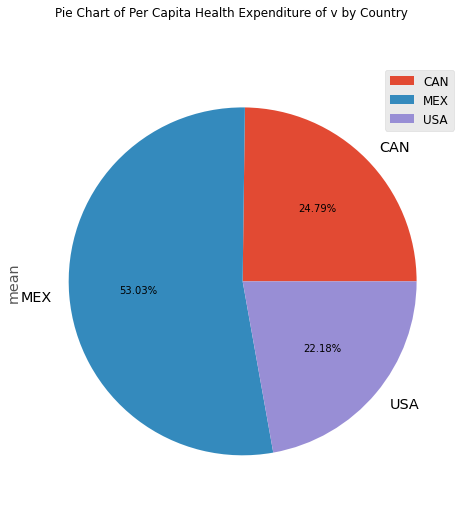

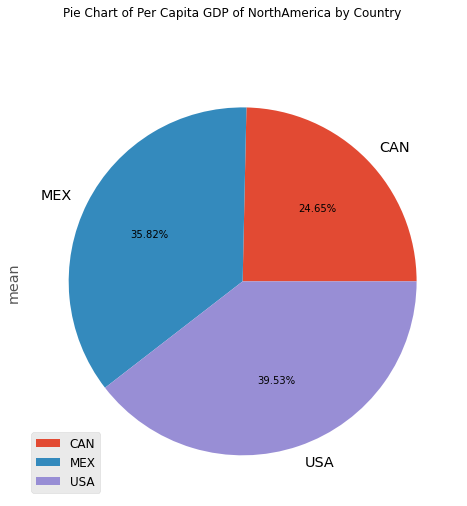

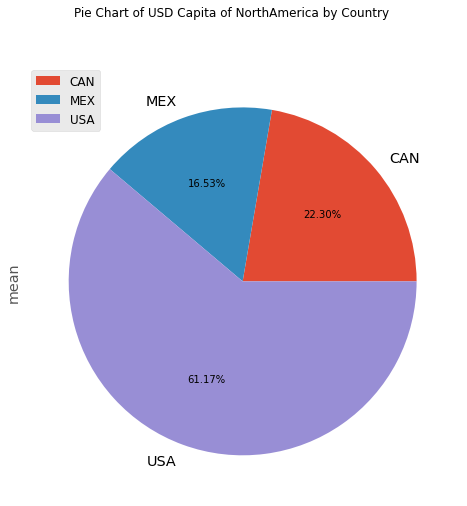

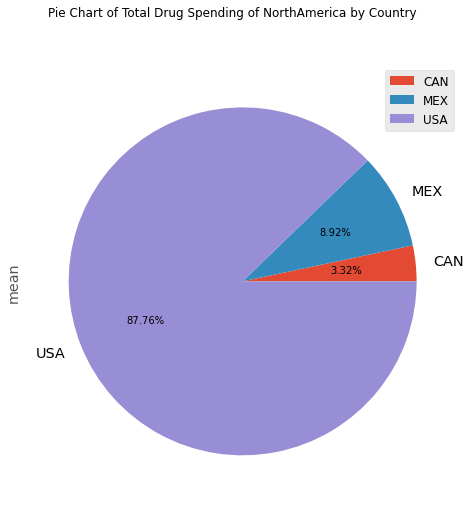

In [49]:
# Pie chart for Oceania
ds_NorthAmerica_pie = ds_NorthAmerica.groupby(drug_spending_df['Location']).agg(['mean'])

ds_NorthAmerica_pie.Per_Capita_HealthXP.plot.pie(
    subplots =True,
    figsize=(12,8), 
    radius= 1.0, 
    autopct='%0.2f%%', 
    title ='Pie Chart of Per Capita Health Expenditure of v by Country')

ds_NorthAmerica_pie.PC_GDP.plot.pie(
    subplots =True,
    figsize=(12,8), 
    radius= 1.0, 
    autopct='%0.2f%%', 
    title ='Pie Chart of Per Capita GDP of NorthAmerica by Country')

ds_NorthAmerica_pie.USD_Cap.plot.pie(
    subplots =True,
    figsize=(12,8), 
    radius= 1.0, 
    autopct='%0.2f%%', 
    title ='Pie Chart of USD Capita of NorthAmerica by Country')

ds_NorthAmerica_pie.Tot_Spend.plot.pie(
    subplots =True,
    figsize=(12,8), 
    radius= 1.0, 
    autopct='%0.2f%%', 
    title ='Pie Chart of Total Drug Spending of NorthAmerica by Country')

## Feature Engineering and Modeling

In [51]:
import statsmodels.formula.api as smf
from typing import List
from operator import add
from toolz import reduce, partial
from numpy import *
from matplotlib import *

#### Autocorrelation

In [52]:
drug_spending_df.head()

,Location,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend,Region,Decade
0,AUS,1971,15.99,0.73,35.72,462.11,Oceania,70s
1,AUS,1972,15.09,0.69,36.06,475.11,Oceania,70s
2,AUS,1973,15.12,0.68,39.87,533.47,Oceania,70s
3,AUS,1974,14.77,0.76,47.56,652.65,Oceania,70s
4,AUS,1975,11.85,0.68,47.56,660.76,Oceania,70s


In [53]:
drug_spending_df_sub1 = drug_spending_df[['Year', 'USD_Cap']]
drug_spending_df_sub2 = drug_spending_df[['Year', 'Tot_Spend']]
drug_spending_Cap_spend = drug_spending_df_sub1.set_index('Year').join(drug_spending_df_sub2.set_index('Year'))
drug_spending_Cap_spend.head()

,USD_Cap,Tot_Spend
Year,,
1970,41.92,404.74
1970,41.92,735.93
1970,41.92,107.77
1970,41.92,2455.64
1970,41.92,3501.12


In [54]:
correlation = drug_spending_df_sub1['USD_Cap'].corr(drug_spending_df_sub2['Tot_Spend'])
print("Correlation of Per Capita Expenditure and Total Spending: ", correlation)

Correlation of Per Capita Expenditure and Total Spending:  0.4945005974143577


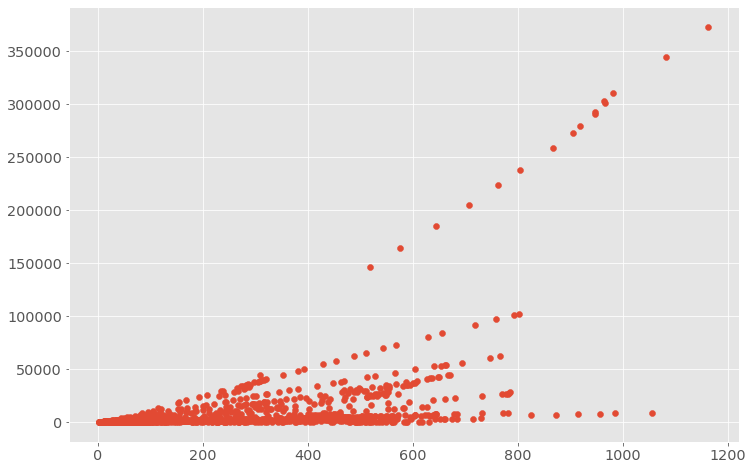

In [55]:
plt.scatter(drug_spending_df_sub1['USD_Cap'], drug_spending_df_sub2['Tot_Spend'])
plt.show()

In [56]:
correlation1 = drug_spending_df_sub1['USD_Cap'].corr(drug_spending_df_sub2['Tot_Spend'])
print("Correlation of levels: ", correlation1)

changes = drug_spending_Cap_spend.pct_change()
correlation2 = changes['USD_Cap'].corr(changes['Tot_Spend'])
print("Correlation of changes: ", correlation2)

Correlation of levels:  0.4945005974143577
Correlation of changes:  -0.003806142650093206


#### Linear Regression

In [57]:
features = ["USD_Cap", "PC_GDP"]

inverted = (drug_spending_df.pivot_table(index="Region", columns="Year", )[features].T) # flip the table to have one column per Location

inverted.head()

Region          Asia     Europe  North America  Oceania
        Year                                           
USD_Cap 1970  17.050  27.302500          34.51      NaN
        1971  21.595  30.943333          37.49    30.16
        1972  23.690  34.334286          38.28    36.06
        1973  22.520  38.351429          40.48    39.87
        1974  24.155  43.292857          40.56    47.56

In [58]:
inverted['North America'].fillna(0)
inverted = inverted[inverted['North America'].notna()]
inverted = inverted[inverted['North America'] != 'nan']

In [59]:
inverted['Oceania'].fillna(0)
inverted = inverted[inverted['Oceania'] != 'na']
inverted = inverted[inverted['Oceania'].notna()]

In [60]:
inverted.isnull().sum()

Region
Asia             0
Europe           0
North America    0
Oceania          0
dtype: int64

In [61]:
# Define y and x variables
y = inverted[['North America']].values
X = inverted.drop(columns='North America').values

In [62]:
y

array([[3.74900000e+01],
       [3.82800000e+01],
       [4.04800000e+01],
       [4.05600000e+01],
       [4.43700000e+01],
       [4.69700000e+01],
       [5.05100000e+01],
       [5.53000000e+01],
       [6.18300000e+01],
       [6.87000000e+01],
       [8.28800000e+01],
       [9.04400000e+01],
       [9.84800000e+01],
       [1.09510000e+02],
       [1.24340000e+02],
       [1.41550000e+02],
       [1.52160000e+02],
       [1.67070000e+02],
       [1.83940000e+02],
       [2.01820000e+02],
       [2.22110000e+02],
       [2.44540000e+02],
       [2.63390000e+02],
       [2.72080000e+02],
       [2.87510000e+02],
       [2.92030000e+02],
       [3.20270000e+02],
       [3.52800000e+02],
       [2.30330000e+02],
       [3.38910000e+02],
       [3.74183333e+02],
       [4.14103333e+02],
       [4.85956667e+02],
       [5.19406667e+02],
       [5.52210000e+02],
       [5.90993333e+02],
       [6.15460000e+02],
       [6.26043333e+02],
       [6.55526667e+02],
       [6.71603333e+02],


In [63]:
X

array([[2.15950000e+01, 3.09433333e+01, 3.01600000e+01],
       [2.36900000e+01, 3.43342857e+01, 3.60600000e+01],
       [2.25200000e+01, 3.83514286e+01, 3.98700000e+01],
       [2.41550000e+01, 4.32928571e+01, 4.75600000e+01],
       [3.40400000e+01, 5.00955556e+01, 4.75600000e+01],
       [3.31050000e+01, 4.99575000e+01, 4.43150000e+01],
       [3.67500000e+01, 5.20766667e+01, 4.76500000e+01],
       [4.47150000e+01, 5.82433333e+01, 5.08000000e+01],
       [5.46650000e+01, 6.34300000e+01, 4.97700000e+01],
       [8.50833333e+01, 7.44475000e+01, 5.71500000e+01],
       [5.53833333e+01, 7.79227273e+01, 6.17050000e+01],
       [6.35733333e+01, 8.45081818e+01, 6.78850000e+01],
       [7.70933333e+01, 8.99336364e+01, 7.44500000e+01],
       [9.34575000e+01, 9.44600000e+01, 7.89850000e+01],
       [1.00065000e+02, 1.14811538e+02, 8.28350000e+01],
       [1.09182500e+02, 1.17166667e+02, 9.29600000e+01],
       [1.19637500e+02, 1.23765833e+02, 1.01385000e+02],
       [1.64623333e+02, 1.38115

In [64]:
# Split the data using train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)
print(X_train.shape, y_train.shape)

(74, 3) (74, 1)


In [65]:
# Create the model
rModel = sm.OLS(y_train, X_train)
# Fit the model with fit() 
fit_model = rModel.fit()

In [66]:
fit_model.summary() # Evaluate model

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              4961.
Date:                Fri, 17 Sep 2021   Prob (F-statistic):                    2.23e-82
Time:                        23:47:20   Log-Likelihood:                         -319.02
No. Observations:                  74   AIC:                                      644.0
Df Residuals:                      71   BIC:                                      650.9
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4975      0.129      3.854      0.000       0.240       0.755
x2             0.8959      0.142      6.298      0.000       0.612       1.180
x3            -0.1016      0.078     -1.295      0.200      -0.258       0.055
==============================================================================
Omnibus:                       62.653   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              552.880
Skew:                          -2.292   Prob(JB):                    8.78e-121
Kurtosis:                      15.582   Cond. No.                         30.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
y_predict = fit_model.predict(X_test)

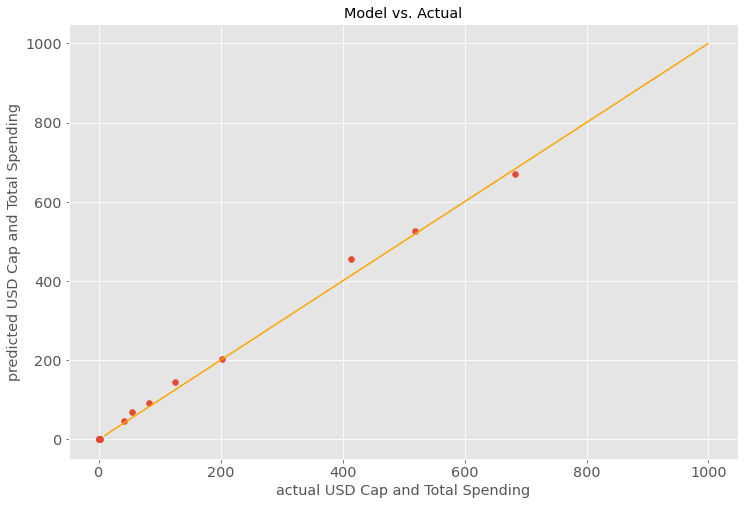

In [68]:
# Make scatterplot
_ = plt.scatter(y_test, y_predict)
_ = plt.title("Model vs. Actual")
_ = plt.xlabel("actual USD Cap and Total Spending")
_ = plt.ylabel("predicted USD Cap and Total Spending")

# Add a line for perfect correlation. Can you see what this line is doing? Use plot()
_ = plt.plot([x for x in range(10,1000)], [x for x in range(10,1000)], color = "orange")
plt.show()

### North America data - Total Spending

In [354]:
drug_spending_df_subset = drug_spending_df[['Year', 'Per_Capita_HealthXP','PC_GDP', 'USD_Cap', 'Tot_Spend','Region']]
drug_spending_df_subset.head()

,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend,Region
0,1971,15.99,0.73,35.72,462.11,Oceania
1,1972,15.09,0.69,36.06,475.11,Oceania
2,1973,15.12,0.68,39.87,533.47,Oceania
3,1974,14.77,0.76,47.56,652.65,Oceania
4,1975,11.85,0.68,47.56,660.76,Oceania


In [355]:
ds_NorthAmerica_spend = drug_spending_df_subset[drug_spending_df_subset['Region'].map(lambda values: 'North America' in values)]

In [356]:
ds_NorthAmerica_spend.head()

,Year,Per_Capita_HealthXP,PC_GDP,USD_Cap,Tot_Spend,Region
111,1970,11.96,0.76,34.51,735.93,North America
112,1971,11.53,0.76,37.49,811.56,North America
113,1972,10.96,0.72,38.28,841.89,North America
114,1973,10.94,0.68,40.48,905.51,North America
115,1974,10.03,0.61,40.56,923.69,North America


In [357]:
ds_NorthAmerica_spend['Year']

111    1970
112    1971
113    1972
114    1973
115    1974
       ... 
967    2011
968    2012
969    2013
970    2014
971    2015
Name: Year, Length: 78, dtype: int64

In [358]:
ds_NorthAmerica_spend = ds_NorthAmerica[['Year', 'PC_GDP','Tot_Spend']]
ds_NorthAmerica_spend.head()
ds_NorthAmerica_spend.shape

(78, 3)

In [359]:
ds_NorthAmerica_spend.head()

,Year,PC_GDP,Tot_Spend
111,1970,0.76,735.93
112,1971,0.76,811.56
113,1972,0.72,841.89
114,1973,0.68,905.51
115,1974,0.61,923.69


In [360]:
ds_NorthAmerica_spend['Year'].unique()

array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015], dtype=int64)

In [361]:
#c = ds_NorthAmerica_spend.set_index('Year')

In [362]:
#c = y.sort_index()
#c

Text(0.5, 1.0, 'North America Total Drug Spending 1970-2015')

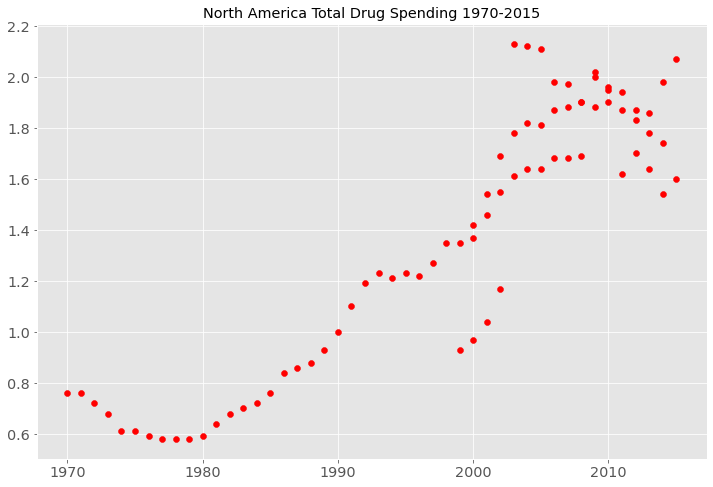

In [363]:
#y.plot(figsize=(15, 6))
#plt.show()
pc_gdp = ds_NorthAmerica_spend['PC_GDP']
time = ds_NorthAmerica_spend['Year']

plt.scatter(time, pc_gdp, c = 'red')
plt.title('North America Total Drug Spending 1970-2015')

### Decomposition

In [364]:
#

#### Seasonal Naive

In [365]:
#ds_NorthAmerica_spend = ds_NorthAmerica_spend.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
#ds_NorthAmerica_spend['Year'] = pd.to_datetime(ds_NorthAmerica_spend['Year'])

In [410]:
ds_NorthAmerica_spend2 = ds_NorthAmerica_spend[['Year','Tot_Spend']]
ds_NorthAmerica_spend2.head()

,Year,Tot_Spend
111,1970,735.93
112,1971,811.56
113,1972,841.89
114,1973,905.51
115,1974,923.69


In [411]:
ds_NorthAmerica_spend2['Year'].unique()

array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015], dtype=int64)

In [412]:
ds_NorthAmerica_spend2['Year']
ds_NorthAmerica_spend2 = ds_NorthAmerica_spend2[ds_NorthAmerica_spend['Year'].notnull()].copy()

In [413]:
ds_NorthAmerica_spend2.head()

,Year,Tot_Spend
111,1970,735.93
112,1971,811.56
113,1972,841.89
114,1973,905.51
115,1974,923.69


In [414]:
from datetime import datetime, timedelta
ds_NorthAmerica_spend2['Year'] = pd.to_timedelta(ds_NorthAmerica_spend2['Year'])

In [415]:
ds_NorthAmerica_spend2.head()

,Year,Tot_Spend
111,0 days 00:00:00.000001970,735.93
112,0 days 00:00:00.000001971,811.56
113,0 days 00:00:00.000001972,841.89
114,0 days 00:00:00.000001973,905.51
115,0 days 00:00:00.000001974,923.69


In [416]:
ds_NorthAmerica_spend2['year'] = ds_NorthAmerica_spend2['Year'].dt.year
ds_NorthAmerica_spend2.head()

AttributeError: 'TimedeltaProperties' object has no attribute 'year'

In [409]:
caus_impact_NA = ds_NorthAmerica_spend2.set_index('Year')
caus_impact_NA

,Tot_Spend
Year,
0 days 00:00:00.000001970,735.93
0 days 00:00:00.000001971,811.56
0 days 00:00:00.000001972,841.89
0 days 00:00:00.000001973,905.51
0 days 00:00:00.000001974,923.69
...,...
0 days 00:00:00.000002011,300935.91
0 days 00:00:00.000002012,302768.85
0 days 00:00:00.000002013,310154.01


In [ ]:
caus_impact_NA['Month'] = df['Purchase Date'].dt.month

In [399]:
# Define dates
train_start = '1980'
train_end = '1990'
treat_start = '1991'
treat_end = '2001'
end_date = '2002'

In [334]:
!pip install tfcausalimpact

In [400]:
from causalimpact import CausalImpact
import tensorflow as tf
import tensorflow_probability as tfp

In [401]:
caus_impact_NA

,Tot_Spend
Year,
0 days 00:00:00.000001970,735.93
0 days 00:00:00.000001971,811.56
0 days 00:00:00.000001972,841.89
0 days 00:00:00.000001973,905.51
0 days 00:00:00.000001974,923.69
...,...
0 days 00:00:00.000002011,300935.91
0 days 00:00:00.000002012,302768.85
0 days 00:00:00.000002013,310154.01


In [407]:
caus_impact_NA.boxplot

In [403]:
pre_period = caus_impact_NA.loc[:1990]                      
post_period = caus_impact_NA.loc[1991:]   

TypeError: cannot do slice indexing on TimedeltaIndex with these indexers [1990] of type int

In [379]:
pre_period

,Year,Tot_Spend
0,1970,735.93
1,1971,811.56
2,1972,841.89
3,1973,905.51
4,1974,923.69
5,1975,1029.71
6,1976,1104.57
7,1977,1201.96
8,1978,1329.14
9,1979,1501.05


In [383]:
pre_period['Year'] = pd.to_datetime(pre_period['Year'])

In [384]:
pre_period

,Year,Tot_Spend
0,1970-01-01 00:00:00.000001970,735.93
1,1970-01-01 00:00:00.000001971,811.56
2,1970-01-01 00:00:00.000001972,841.89
3,1970-01-01 00:00:00.000001973,905.51
4,1970-01-01 00:00:00.000001974,923.69
5,1970-01-01 00:00:00.000001975,1029.71
6,1970-01-01 00:00:00.000001976,1104.57
7,1970-01-01 00:00:00.000001977,1201.96
8,1970-01-01 00:00:00.000001978,1329.14
9,1970-01-01 00:00:00.000001979,1501.05


In [380]:
#ci = CausalImpact(caus_impact_NA, pre_period, post_period)
# subtract 1 year from test data
dates = (post_period['Year'] - np.timedelta64(1, 'Y') + \
        np.timedelta64(1, 'D')).values.astype('datetime64[D]') 
seasonal_naive_sales = pre_period[pre_period['date'].astype('datetime64[D]').isin(dates)]['Tot_Spend'] 

# make a copy of the test_df and make naive predictions for the last 3 months of 2017
sn_pred_df = test_df.copy().drop('sales', axis=1)
sn_pred_df['seasonal_naive_sales'] = pd.DataFrame(seasonal_naive_sales).set_index(post_period.index)
sn_pred_df.head()

TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Timedelta'

In [188]:
ds_NorthAmerica_spend_date = ds_NorthAmerica_spend.drop(columns='Year')

In [189]:
ds_NorthAmerica_spend_date

,PC_GDP,Tot_Spend,year,month,day,weekday
111,0.76,735.93,1970,1,1,3
112,0.76,811.56,1970,1,1,3
113,0.72,841.89,1970,1,1,3
114,0.68,905.51,1970,1,1,3
115,0.61,923.69,1970,1,1,3
...,...,...,...,...,...,...
967,1.94,300935.91,1970,1,1,3
968,1.87,302768.85,1970,1,1,3
969,1.86,310154.01,1970,1,1,3
970,1.98,344495.16,1970,1,1,3


In [132]:
from statsmodels.tsa.arima_model import ARMA
mod = ARMA(ds_NorthAmerica, order(0,1))
res = mod.fit()
res.plot_predict(start='1970', end='')

In [112]:
# Split the series to predict 1980-2000
spend_df = ds_NorthAmerica_spend.set_index('Year')
train_df = spend_df.loc[:'2000'].reset_index(drop=False)                         
test_df = spend_df.loc['2000':].reset_index(drop=False)

train_df.head()

,Year,PC_GDP,Tot_Spend,year,month,day,weekday
0,1970-01-01 00:00:00.000001970,0.76,735.93,1970,1,1,3
1,1970-01-01 00:00:00.000001971,0.76,811.56,1970,1,1,3
2,1970-01-01 00:00:00.000001972,0.72,841.89,1970,1,1,3
3,1970-01-01 00:00:00.000001973,0.68,905.51,1970,1,1,3
4,1970-01-01 00:00:00.000001974,0.61,923.69,1970,1,1,3


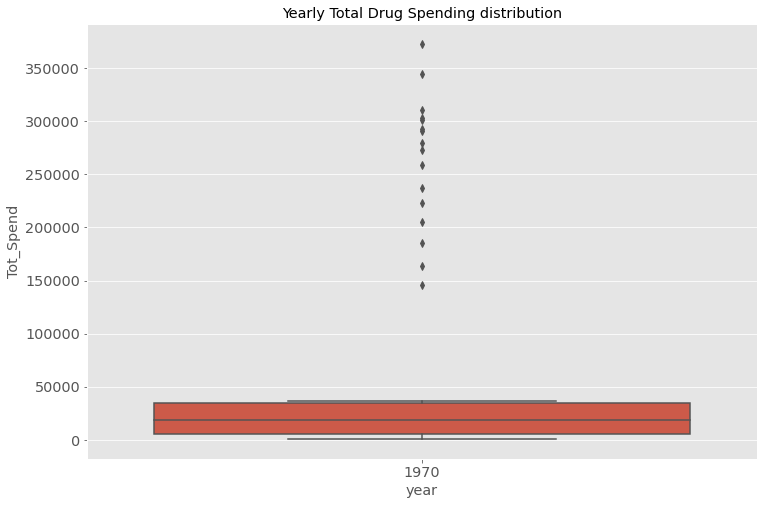

In [88]:
import seaborn as sn
plot = sn.boxplot(x='year', y='Tot_Spend', data=ds_NorthAmerica_spend)
_ = plot.set(title='Yearly Total Drug Spending distribution')

In [84]:
from statsmodels.tsa.seasonal import seasonal_decompose

# subtract 1 year from test data
dates = (test_df['Year'] - np.timedelta64(1, 'Y') + \
        np.timedelta64(1, 'D')).values.astype('datetime64[D]') 
seasonal_naive_sales = train_df[train_df['Year'].astype('datetime64[D]').isin(dates)]['Tot_Spend'] 

# make a copy of the test_df and make naive predictions for the last 3 months of 2017
sn_pred_df = test_df.copy().drop('Tot_Spend', axis=1)
sn_pred_df['seasonal_naive_sales'] = pd.DataFrame(seasonal_naive_sales).set_index(test_df.index)
sn_pred_df.head()

,Year,PC_GDP,year,month,day,weekday,seasonal_naive_sales


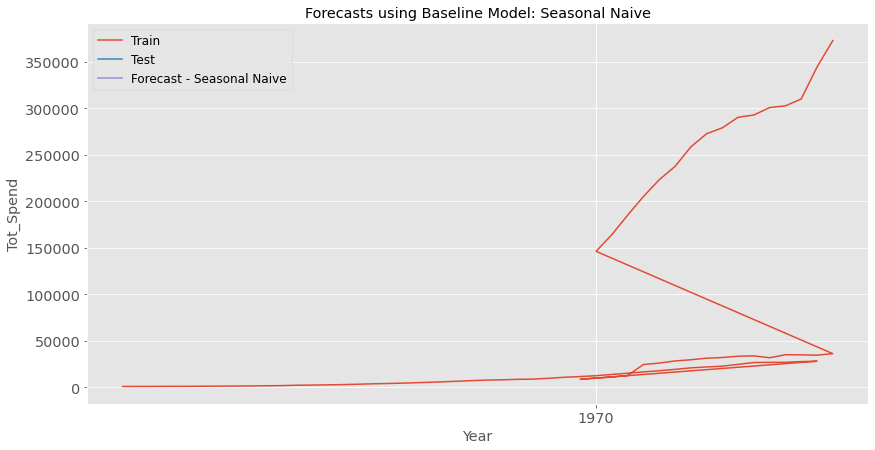

In [85]:
plt.figure(figsize=(14,7))
plt.plot(train_df['Year'], train_df['Tot_Spend'], label='Train')
plt.plot(test_df['Year'], test_df['Tot_Spend'], label='Test')
plt.plot(sn_pred_df['Year'], sn_pred_df['seasonal_naive_sales'], label='Forecast - Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('Year')
plt.ylabel('Tot_Spend')
plt.title('Forecasts using Baseline Model: Seasonal Naive')
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression().fit(X, y).coef_
weights_lr.round(3)

In [ ]:
!git clone https://github.com/OscarEngelbrektson/SyntheticControlMethods

In [ ]:
!ls

In [ ]:
cd SyntheticControlMethods

In [ ]:
from SyntheticControlMethods import Synth, DiffSynth

In [ ]:
features = ["Tot_Spend"]

inverted = (drug_spending_df.pivot_table(index="Region", columns="Year", )[features].T) # flip the table to have one column per Location

inverted.head()

In [ ]:
inverted.index

In [ ]:
features = ["PC_GDP"]

inverted2 = (drug_spending_df.pivot_table(index="Region", columns="Year", )[features].T) # flip the table to have one column per Location

inverted2.head()

In [ ]:
#inverted.join(inverted2, on='Region', how='left', lsuffix='_left', rsuffix='_right')

In [ ]:
inverted['North America'].fillna(0)

In [ ]:
inverted['North America'].unique()

In [ ]:
inverted = inverted[inverted['North America'] != 'nan']
inverted = inverted[inverted['North America'].notna()]

In [ ]:
#inverted.isnull().sum()
inverted['North America'].unique()

In [ ]:
inverted['Oceania'].fillna(0)
inverted= inverted[inverted['Oceania'] != 'na']
inverted= inverted[inverted['Oceania'].notna()]

In [ ]:
inverted.isnull().sum()

In [ ]:
inverted2.isnull().sum()

In [ ]:
inverted2['North America'].fillna(0)
inverted2= inverted2[inverted2['North America'] != 'na']
inverted2= inverted2[inverted2['North America'].notna()]

In [ ]:
inverted2['Oceania'].fillna(0)
inverted2= inverted2[inverted2['Oceania'] != 'na']
inverted2= inverted2[inverted2['Oceania'].notna()]

In [ ]:
inverted2.isnull().sum()

In [ ]:
inverted.shape

In [ ]:
inverted2.shape

In [ ]:
inverted.set_index('Year').join(inverted2.set_index('Year'))

In [ ]:
import statsmodels.api as sm
inverted['Tot_Spend'] = inverted['PC_GDP'].pct_change()

In [ ]:
drug_spending_df_subset = drug_spending_df[['Year', 'Per_Capita_HealthXP','PC_GDP', 'USD_Cap', 'Tot_Spend','Region']]

In [ ]:
drug_spending_df_subset.head()

In [ ]:
drug_spending_df_subset.info()

In [ ]:
drug_spending_df_subset[drug_spending_df_subset['Region'].map(lambda values: 'North America' in values)]

In [ ]:
ds_NorthAmerica_subset = ds_NorthAmerica[['Year', 'Tot_Spend']]

In [ ]:
#drug_spending_df_subset['Year'] = pd.to_datetime(drug_spending_df_subset['Year'], format='%Y-%m')

In [ ]:
y = ds_NorthAmerica_subset.set_index('Year')

In [ ]:
y.sort_index(inplace='True')

In [ ]:
y.index

In [ ]:
y = y.sort_index()

In [ ]:
y.isnull().sum()

In [ ]:
y.plot(figsize=(15, 6))
plt.show()

In [ ]:
from pandas import Series
pyplot.figure(1)
pyplot.subplot(211)
y.Tot_Spend.hist()
pyplot.subplot(212)
y.Tot_Spend.plot(kind='kde')
pyplot.show()

In [ ]:
#Rolling statistics
rolmean = pd.rolling_mean(y, window=12)
rolstd = pd.rolling_std(y, window=12)

#Plot rolling statistics:
orig = plt.plot(y, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
from causalimpact import CausalImpact

In [ ]:
dated_data = drug_spending_df_subset.set_index(pd.date_range(start='1971', periods=len(data)))

pre_period = ['20200101', '20200311']
post_period = ['20200312', '20200409']

figsize = (20, 6)
ci = CausalImpact(dated_data, pre_period, post_period)

In [ ]:
#Fit synthetic control
sc = Synth(drug_spending_df_subset, "Per_Capita_HealthXP", "Region", "Year", 1990, "North America", n_optim=100)

In [ ]:
# Define y and x variables
y = inverted['North America'].values # 
X = inverted.drop(columns='North America').values  # other countries

In [ ]:
y

In [ ]:
X

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25)

In [ ]:
# use Lasso
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold

In [ ]:
model=Lasso().fit(X, y)
print(model)
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False) 


In [ ]:
score = model.score(X, y)
ypred = model.predict(xtest)
mse = mean_squared_error(ytest, ypred)
print("Alpha:{0:.2f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}"
    .format(model.alpha, score, mse, np.sqrt(mse)))

In [ ]:
alphas = [0.1,0.3, 0.5, 0.8, 1]
lassocv = LassoCV(alphas=alphas, cv=5).fit(X,y)
print(lassocv)
LassoCV(alphas=[0.1, 0.3, 0.5, 0.8, 1], copy_X=True, cv=5, eps=0.001,
    fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False) 

In [ ]:
score = lassocv.score(X,y)
ypred = lassocv.predict(xtest)
mse = mean_squared_error(ytest,ypred)
print("Alpha:{0:.2f}, R2:{1:.3f}, MSE:{2:.2f}, RMSE:{3:.2f}"
    .format(lassocv.alpha_, score, mse, np.sqrt(mse)))

In [ ]:
x_ax = range(len(xtest))
plt.scatter(x_ax, ytest, s=5, color="blue", label="original")
plt.plot(x_ax, ypred,lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [ ]:
from SyntheticControlMethods import Synth

In [ ]:
tr_unit = drug_spending_df[drug_spending_df.Location == 'North America']
tr_unit = tr_unit[tr_unit.Year < 1990]
y_tr = np.array(tr_unit.PC_GDP)

ctr_units = drug_spending_df[drug_spending_df.Location!= 'North America']
ctr_units = ctr_units[ctr_units.Year < 1990]
y_ctr = np.array(ctr_units.PC_GDP)

tr_unit_all =  drug_spending_df[ drug_spending_df.Location == 'North America']
y_tr_all = np.array(tr_unit_all.PC_GDP)

ctr_units_all = drug_spending_df[drug_spending_df.Location!= 'North America']
y_ctr_all = np.array(ctr_units_all.PC_GDP)

In [ ]:
print(y_ctr_all)

In [ ]:
X1 = drug_spending_df[drug_spending_df.Location == 'USA']
X1 = X1[X1.Year < 1990]
X1 = X1.drop(['Year','Per_Capita_HealthXP','USD_Cap', 'Tot_Spend', 'Region', 'Decade'], axis=1)
X1 = X1.set_index(np.arange(len(X1)) //30).mean(level=0)
X1 = X1.values

X0 = drug_spending_df[drug_spending_df.Location != 'USA']
X0 = X0[X0.Year < 1990]
X0 = X0.drop(['Year','Per_Capita_HealthXP','USD_Cap', 'Tot_Spend', 'Region', 'Decade'], axis=1)
X0 = X0.set_index(np.arange(len(X0)) // 30).mean(level=0)
X0 = X0.values
X0.shape, X1.shape

In [ ]:
import cvxpy as cvx

# Construct the problem
w = cvx.Variable((1, 11), nonneg=True)

objective = cvx.Minimize(cvx.sum_squares(X1 - w @ X0))

constraints = [cvx.sum(w) == 1]

prob = cvx.Problem(objective, constraints)

# The optimal objective value is returned by prob.solve()
result = prob.solve(verbose=True)

print('The optimal objective value: ',result,'\n\nWeights: ',w.value)

In [ ]:
features = ["USD_Cap", "PC_GDP"]

inverted = (drug_spending_df.pivot_table(index="Region", columns="Year", )[features].T) # flip the table to have one column per Location

inverted.head()

In [ ]:
inverted.isnull().sum()

In [ ]:
inverted['North America'].fillna(0)

In [ ]:
inverted['Oceania'].fillna(0)

In [ ]:
# Sanity check
#inverted.isnull().sum()
#inverted['North America'].unique()
inverted = inverted[inverted['North America'] != 'na']
inverted = inverted[inverted['North America'].notna()]

In [ ]:
#inverted['North America'].unique()
#inverted.isnull().sum()
inverted = inverted[inverted['Oceania'] != 'na']
inverted = inverted[inverted['Oceania'].notna()]

In [ ]:
#inverted['Oceania'].unique()
inverted.isnull().sum()

In [ ]:
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression().fit(X, y).coef_
weights_lr.round(3)

In [ ]:
NorthAmerica_synth_lr = (drug_spending_df.pivot(index='Year', columns="Region")["USD_Cap"].values.dot(weights_lr))

In [ ]:
lambda x: np.sum(x) - 1

In [ ]:
from scipy.optimize import fmin_slsqp

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

In [ ]:
USA_weights = get_w(X, y)
print("Sum:", USA_weights.sum())                                            
np.round(USA_weights, 4)